# Filtering and analysing Singapore-based tweets - exploratory data analysis

### Introduction
**Challenge**: Collecting tweets by ***Singapore-based users*** from streaming Twitter data.

Previous research works relied on relaxed and limited heuristics resulting in noisy data containing false positives of Singapore-based users' tweets. 
This challenging problem is addressed with the help of plausible heuristics to gather Singapore-based users' tweets. 
The data analyses suggest that curated tweets give credible insights about Singapore. 

First, the Twitter streaming data is ingested into MongoDB, data wrangling is performed to curate Singapore-based tweets based on heuristics. 
Exploratory data analysis is then performed on the curated tweets. 

**Factual**: 
- Less than 0.01% of Twitter users will push tweets with their GPS locations.
- Estimated Singapore Twitter Users 1.7M [(Source)](https://www.statista.com/statistics/490600/twitter-users-singapore/#:~:text=Number%20of%20Twitter%20users%20in%20Singapore%202019%2D2021&text=In%202021%2C%20there%20were%20over,between%2025%2D34%20years%20old)
- Tweets grabbed from streaming data will have 0 favorites or retweets, since the tweets are already captured even before others react :D 

Check out the [Twitter streaming API response](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) for a better understanding of the notebooks. 

### [Table of Contents](#cell2)

* 1\. [Heuristics for filtering Singapore-based users' tweets from streaming twitter API](#cell1)
* 2\.     [Loading the data (csv files)](#cell2)
* 3\. [Cleaning and processing the data](#cell3)
    * 3.1. [Datetime cleanup and formatting](#cell31)
    * 3.2. [Geocoding fixes](#cell32)
<!--         * 3.2.1 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.2 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.3 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.4 [Replacing nan with 'Unknown'](#cell321) -->
    * 3.3. [Filtering out non-Singapore accounts - reducing false positives and false negatives](#cell33)
    * 3.4. [Processing the tweets and quoted tweets](#cell34)
* 4\. [Exploratory data analysis of Singapore geo-coded tweets](#cell4) 
    * 4.1. [Basics](#cell41)
    * 4.2. [Sentiment analysis of tweets and quoted tweets](#cell42) 
    * 4.3. [Analysing Singapore users](#cell43)
    * 4.4. [Analysing potentially sensitive tweets (PST) with links](#cell44)
    * 4.5. [Popular hashtags](#cell45)
    * 4.6. [Popular mentions](#cell46)
    * 4.7. [Regional analysis](#cell47)
    * 4.8. [Others](#cell48)

In [118]:
import re
import sys
import os
import time
import glob 
import json
import random
from datetime import datetime  as dt

import collections as col

import numpy as np
import pandas as pd

# import functools as ft
import itertools as it

# visualizations
import plotly.express as px
import matplotlib.pyplot as plt

In [119]:
import warnings
warnings.filterwarnings("ignore")

In [120]:
# to import the desired function from the module hierarchy
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 1. Heuristics for filtering Singapore-based users' tweets from streaming twitter API <a id="cell1"></a>

##### Tweets from the streaming twitter API are first ingested into MongoDB. The below heuristics are then applied on the collected tweets to fetch Singapore-based users' tweets:   

**Step 1 -  Collection of potential Singapore-based twitter users:** Users who follow at least 2 of the Singapore based twitter accounts listed below: 

`Singapore based twitter handles
'mindefsg', 'MOEsg', 'sporeMOH', 'LTAsg', 'SMRT_Singapore', 'SBSTransit_Ltd', 'SingaporeHDB', 'MNDSingapore', 'mhasingapore', 'SingaporePolice', 'URAsg',  'MAS_sg', 'MOFsg', 'ICASingapore', 'SingaporeMCI', 'nlbsingapore', 'IMDAsg',  'NEAsg', 'nparksbuzz', 'SGSportsHub', 'govsingapore', 'SingaporeCAAS', 'MFAsg',
 ‘iremembersg', 'youthsg', 'NUSingapore', 'NTUsg', 'sgSMU', 'sutdsg', 'SGRedCross',  'STcom', 'ChannelNewsAsia', 'TODAYonline', 'asiaonecom', 'thenewpaper', 'MothershipSG', 'Singtel', 'StarHub', 'MyRepublicSG', 'M1Singapore', 'temasekpoly', 'singaporetech','SingaporePoly', 'PUBsingapore', 'NgeeAnnNP', 'ITESpore', 'mediacorp', 'YahooSG',  'TimeOutSG', 'VisitSingapore', 'stb_sg', 'GovTechSG', 'SGmagazine', 'mySingapore',  'sgelection', 'SGAG_SG', 'TEDxSingapore', 'STATravelSG', 'STPix'`
 
##### Collected users count: 888739

The file `get_sg_users.py` contains the code for Step 2.

The file `/data/min_2_following_users.txt` contains the list of collected twitter user ids.

**Step 2 - Filtering users' tweets:** Tweets from a user whose:
1. **Twitter user id** in the collected ids as mentioned above OR
2. **Place** is set to Singapore OR
3. **Location** containing `'sg', 'spore', 'singapore', 'singapura'`
4. **Description** containing `'spore', 'singapore', 'singapura'`

The file `get_sg_tweets.py` contains the code for Step 2.

**Step 3 - Filtering tweets with geocoded country as 'Singapore'**


# 2. Loading the data (csv files) <a id="cell2"></a>
##### Loading and merging the fragmented csvs files. The files contain the collected Singapore-based tweets.

In [ ]:
BASE_PATH = '../data/'
SG_TWEETS_PATH = 'fragmented_data/tweets_sg/'
SG_TWEETS_ENGAGEMENTS_PATH = 'fragmented_data/tweets_engagements_sg/'

In [ ]:
# csvs containing users and tweets specific data
tw_data = pd.concat([pd.read_csv(csv_file, index_col=0, header=0, engine='python') for csv_file in glob.glob(
            os.path.join(BASE_PATH, SG_TWEETS_PATH, "*.csv"))], axis=0, ignore_index=True)

# csvs containing the collected tweets' engagement data - retweets, replies and quoted tweets
tw_eng_data = pd.concat([pd.read_csv(csv_file, index_col=0, header=0, engine='python') for csv_file in glob.glob(
            os.path.join(BASE_PATH, SG_TWEETS_ENGAGEMENTS_PATH, "*.csv"))], axis=0, ignore_index=True)

In [123]:
tw_data.head(5)

,tweet_text,tweet_time,tweet_id,tweet_lang,tweet_possibly_sensitive,entity_image_url,entity_mentions,entity_hashtags,entity_link_url,user_id,user_name,user_screenname,user_friends_count,user_followers_count,user_verified,user_location,user_desc,user_geo_coding,user_geo_tagging
0,RT @NickHudsonCT: Read the replies! People see...,Fri Aug 06 04:50:47 +0000 2021,1423506816089133057,en,NaN,NaN,NickHudsonCT,NaN,NaN,1223307253236817922,Coronavirus,JayChance12,4299.0,450,False,ElysiumTimeIn fr all on Earth,#biotechnology #policy #risk #prevention #miti...,NaN,NaN
1,RT @Simple_Peasant1: I hope Dr. Kumar clarifie...,Fri Aug 06 04:50:51 +0000 2021,1423506836423020548,en,NaN,NaN,Simple_Peasant1,NaN,NaN,117753607,Timbalan Pengarah J-KOM,fakrul07,2978.0,1194,False,Kuala Lumpur Federal Territory,I've heard that evil come disguised,Malaysia|MY,NaN
2,RT @jenniferatntd: The world is totally differ...,Fri Aug 06 04:50:55 +0000 2021,1423506851417640960,en,NaN,NaN,jenniferatntd,CCP,NaN,2310110660,Journey Home to Singapore,journeyhometosg,266.0,407,False,Singapore,Loves traveling. Dislikes the China Communist ...,Singapore|SG,NaN
3,RT @emma_ducros: Chiche.,Fri Aug 06 04:50:57 +0000 2021,1423506861001748482,en,NaN,NaN,emma_ducros,NaN,NaN,456050432,Nathalie Gourd,NGourd,2540.0,7413,False,"Provence-Alpes-Côte d'Azur, France",Comité de soutien @NicolasSarkozy #MerciNS ❤️ ...,France|FR,NaN
4,"RT @nralyysa: day by day , students are exhaus...",Fri Aug 06 04:51:00 +0000 2021,1423506872175251459,en,NaN,NaN,nralyysa,NaN,NaN,1202498293252546560,mahisha,corgisha,72.0,26,False,Singapore,um let’s just see how this twitter thing works...,Singapore|SG,NaN


In [124]:
tw_eng_data.head(5)

,user_id,user_name,user_screenname,tweet_id,tweet_enagagement_type,replied_to_tweet_id,replied_to_user_id,replied_to_user_screenname,retweeted_tweet_id,retweeted_tweet_time,...,quoted_tweet_id,quoted_tweet_time,quoted_user_id,quoted_user_name,quoted_user_verified,quoted_user_screenname,quoted_user_geo_coding,quoted_user_geo_coding_type,quoted_retweet_count,quoted_favorite_count
0,1.223307e+18,Coronavirus,JayChance12,1423506816089133057,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423391e+18,Thu Aug 05 21:09:49 +0000 2021,1.898686e+08,Tedros Adhanom Ghebreyesus,True,DrTedros,Switzerland|CH,Location,164.0,890.0
1,1.177536e+08,Timbalan Pengarah J-KOM,fakrul07,1423506836423020548,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423460e+18,Fri Aug 06 01:46:11 +0000 2021,1.314752e+08,Dr. Kumar (PSM),False,kumarPsm,NaN,NaN,43.0,112.0
2,2.310111e+09,Journey Home to Singapore,journeyhometosg,1423506851417640960,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423352e+18,Thu Aug 05 18:34:12 +0000 2021,2.313028e+09,Jennifer Zeng 曾錚,False,jenniferatntd,United States|US,Location,33.0,146.0
3,4.560504e+08,Nathalie Gourd,NGourd,1423506861001748482,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423294e+18,Thu Aug 05 14:44:02 +0000 2021,3.839512e+07,franceinfo,True,franceinfo,France|FR,Location,240.0,696.0
4,1.202498e+18,mahisha,corgisha,1423506872175251459,Retweet,NaN,NaN,NaN,1.423205e+18,Thu Aug 05 08:51:15 +0000 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Inner join of tweets and related engagement data 

In [125]:
tweets_data = tw_data.merge(tw_eng_data, on="tweet_id", how = 'inner')
tweets_data.shape

(429877, 47)

# 3. Cleaning and processing the data <a id="cell3"></a>

In [126]:
tweets_data.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

### 3.1. Datetime cleanup and formatting <a id="cell31"></a>

##### Converting to pandas datetime and dropping tweets with improper datetime e.g., string type

In [127]:
tweets_data['tweet_time'] = pd.to_datetime(tweets_data['tweet_time'], errors='coerce')
tweets_data = tweets_data.dropna(subset=['tweet_time'])

##### Adding columns `tweet_datetime` and `tweet_date` for further analyses

In [128]:
tweets_data['tweet_datetime'] = tweets_data.tweet_time.dt.strftime('%Y-%m-%d %H')
tweets_data['tweet_date'] = tweets_data.tweet_time.dt.strftime('%Y-%m-%d')

### 3.2. Geocoding fixes <a id="cell32"></a>

#### What is **geocoding** here? 
Inferring a user's country. 

#### How is geocoding done during data collection?
1. **Coordinate**: If not nullable, latitude, longitude data in `coordinates` object are used to fetch the country using the [Geocoder library] (https://geocoder.readthedocs.io/), ELSE
2. **Place**: If not nullable, Twitter API provides a user's country in the `place` object, ELSE
3. **User-defined location**: (1) [spaCy](https://github.com/explosion/spaCy) to process any place entity in the `location` string (2) Geocoder to fetch the country, ELSE
4. **User-defined description**: (1) [spaCy](https://github.com/explosion/spaCy) to process any place entity in the `description` string (2) Geocoder to fetch the country

Tweets that are not geocoded are rejected. 

#### 3.2.1. Replacing nan with 'Unknown' 

In [129]:
tweets_data['quoted_user_geo_coding'].fillna(value='Unknown', inplace=True)
tweets_data['retweeted_user_geo_coding'].fillna(value='Unknown', inplace=True)
tweets_data['user_geo_coding'].fillna(value='Unknown', inplace=True)

##### Visualizing the distribution of geocoded tweets 

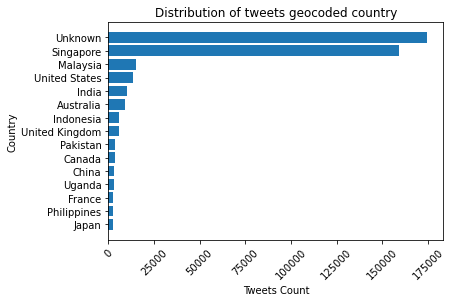

In [130]:
geocoded_tw_data = tweets_data['user_geo_coding']

count_geocoded_tw_data = col.Counter(geocoded_tw_data)
count_geocoded_tw_data = count_geocoded_tw_data.most_common()

# top X countries
TOP_X = 15
countries = [c[0].split('|')[0] for c in count_geocoded_tw_data[:TOP_X]]
counts = [c[1] for c in count_geocoded_tw_data[:TOP_X]]

plt.barh(countries[::-1], counts[::-1])
 
plt.ylabel("Country")
plt.xlabel("Tweets Count")
plt.xticks(rotation=45)
plt.title("Distribution of tweets geocoded country")
plt.show()

#### **Bug fixing**: Users whose location contains a `specific region in Singapore` (e.g., West Singpore, North-east regions) are erroneously coded as `Uganda`

##### Looking for random examples with this error

In [131]:
wrong_geocoded_uganda_users  = list(tweets_data[tweets_data['user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].unique())
for _ in range(5):
    print("https://twitter.com/" + random.choice(wrong_geocoded_uganda_users))

https://twitter.com/xotxfx99
https://twitter.com/fancybootsx
https://twitter.com/nrklshhh
https://twitter.com/hziqvzmn
https://twitter.com/gazzangief


In [132]:
print(tweets_data[tweets_data['user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())
print(tweets_data[tweets_data['quoted_user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())
print(tweets_data[tweets_data['retweeted_user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())

641
22
78


#### 3.2.2. Replacing "Uganda|UG" with "Singapore|SG"

In [133]:
tweets_data['user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)
tweets_data['retweeted_user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)
tweets_data['quoted_user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)

#### 3.2.3. Remove the country code from the data (not required)

In [134]:
tweets_data['quoted_user_geo_coding'] = [c.split('|')[0] for c in tweets_data['quoted_user_geo_coding']]
tweets_data['retweeted_user_geo_coding'] = [c.split('|')[0] for c in tweets_data['retweeted_user_geo_coding']]
tweets_data['user_geo_coding'] = [c.split('|')[0] for c in tweets_data['user_geo_coding']]

#### 3.2.4. Fixing **users with multiple geocoded countries**   

TODO: Fix this during data collection with the help of memoization

1. Geocoded countries is ``greater than 2`` 
    - Highly errorneos, set 'Unknown'
2. Geocoded countries count ``is 2`` 
    - If one of the geocodings is 'Unknown' then set the 'other' known location|
    -  If both the geocodings != 'Unknown' then set both to 'Unknown' (dubious case) 

In [135]:
# getting count of users' decoded locations 
# -- TODO what about quoted_user_screenname retweeted_user_screenname
users_geocode_country_count = tweets_data.groupby('user_screenname_x')['user_geo_coding'].nunique().reset_index(name='count')
# users_geocode_country_count[users_geocode_country_count['count'] > 1].sort_values(by='count', ascending=False)

In [136]:
# list of countries with geocoding > 2
users_geocode_country_count_gtr_2 = users_geocode_country_count[users_geocode_country_count['count'] > 2]['user_screenname_x'].unique()

# Setting location to 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'user_geo_coding'] = 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'retweeted_user_geo_coding'] = 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'retweeted_user_geo_coding'] = 'Unknown'

In [137]:
# TODO: Fix this elegantly
users_geocode_country_count_eq_2 = users_geocode_country_count[users_geocode_country_count['count'] == 2]['user_screenname_x']#.unique()
len(users_geocode_country_count_eq_2)

1437

##### Distribution of geo-coded tweets after corrections

In [138]:
geocoded_tw_data = tweets_data['user_geo_coding']

count_geocoded_tw_data = col.Counter(geocoded_tw_data)
count_geocoded_tw_data = count_geocoded_tw_data.most_common()

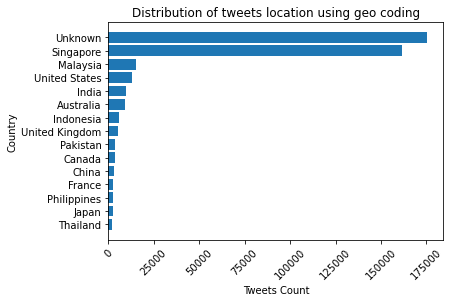

In [139]:
# top X countries
TOP_X = 15
countries = [c[0].split('|')[0] for c in count_geocoded_tw_data[:TOP_X]]
counts = [c[1] for c in count_geocoded_tw_data[:TOP_X]]

plt.barh(countries[::-1], counts[::-1])
 
plt.ylabel("Country")
plt.xlabel("Tweets Count")
plt.xticks(rotation=45)
plt.title("Distribution of tweets location using geo coding")
plt.show()

### 3.3. Filtering out non-Singapore accounts - reducing false positives and false negatives <a id="cell33"></a>

In [140]:
sg_tweets = tweets_data[
                    # 1. geo coded as Singapore
                    (tweets_data['user_geo_coding'] == 'Singapore') | 
                    # 2. user location contains {sg, spore, singapore, singapura}
                    (tweets_data['user_location'].str.contains('sg|spore|singapore|singapura', regex=True, case=False)) |
                    # 3. user description contains {spore, singapore, singapura}
                    (tweets_data['user_desc'].str.contains('spore|singapore|singapura', regex=True, case=False)) |
                     # 4. Quoted tweets by Singaporean and 
                    ((tweets_data['quoted_user_geo_coding'] == 'Singapore') & (tweets_data['user_geo_coding'].isna())) |
                    ((tweets_data['retweeted_user_geo_coding'] == 'Singapore') & (tweets_data['user_geo_coding'].isna()))
            ]
sg_tweets.shape

(181423, 49)

In [141]:
sg_tweets.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

### 3.4. Processing the tweets and quoted tweets <a id="cell34"></a>

In [142]:
sg_tweets['tweet_text'] = [txt.replace('&amp;', '&') if isinstance(txt, str) else '' for txt in sg_tweets['tweet_text']]
sg_tweets['quoted_tweet_text'] = [ txt.replace('&amp;', '&') if isinstance(txt, str) else '' for txt in sg_tweets['quoted_tweet_text']]

##### Processing tweets and quoted tweets

In [143]:
from utils.process_text import TwitterDataProcessing
pre = TwitterDataProcessing()

### 3.5. Predicting sentiment of tweets and quoted tweets <a id="cell35"></a>

In [144]:
processed_tweets = [pre.clean_text(text) for text in sg_tweets['tweet_text']]
sg_tweets['processed_tweet_text'] = processed_tweets

processed_quoted_tweets = [pre.clean_text(text) if isinstance(text, str) == True else '' for text in sg_tweets['quoted_tweet_text']]
sg_tweets['processed_quoted_tweet_text'] = processed_quoted_tweets

##### Adding predicted sentiment for tweets and quoted tweets using off the shelf VADER

Predicting tweets and quoted tweets sentiments

In [145]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment(doc):
    score = analyzer.polarity_scores(doc)['compound']
    # As per vader's repo : https://github.com/cjhutto/vaderSentiment
    if score >= 0.05:
        sentiment = "positive"
    elif score <= -0.05:

        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment

In [146]:
tw_sentiment = [get_sentiment(text) for text in sg_tweets['processed_tweet_text']]
sg_tweets['tweet_sentiment'] = tw_sentiment

quoted_tw_sentiment = [get_sentiment(text) if text != '' else None for text in sg_tweets['processed_quoted_tweet_text']]
sg_tweets['quoted_tweet_sentiment'] = quoted_tw_sentiment

In [147]:
# df_hashtags_data = pd.DataFrame(data=hashtags_data)
pd.DataFrame.to_csv(df_sentiments, "data/output/basics/sentiments.csv")

NameError: name 'df_sentiments' is not defined

In [ ]:
print("---- Duration ---")
print("From {} to {} \n".format(sg_tweets['tweet_date'].min(), sg_tweets['tweet_date'].max()))

print("---- Tweets count---")
print(sg_tweets.shape[0], '\n')

print("---- Attributes---")
sg_tweets.columns

#### Saving the final data with curated sg-tweets for analysis

In [ ]:
sg_tweets = sg_tweets.loc[:, ~sg_tweets.columns.str.contains('^Unnamed')]
pd.DataFrame.to_csv(sg_tweets, BASE_PATH + "sg.csv")

## 4. Exploratory data analysis of Singapore geo-coded tweets <a id="cell4"></a>

### 4.1. Basics <a id="cell41"></a>

In [ ]:
sg_tweets.shape

In [ ]:
total_tweets = len(sg_tweets)
total_tweets

#### Duration

In [ ]:
MAX_DATE = sg_tweets['tweet_date'].max()
MIN_DATE = sg_tweets['tweet_date'].min()
MAX_DATE, MIN_DATE

#### Average tweets per day

In [ ]:
daily_tweets  = sg_tweets.groupby('tweet_date')['tweet_id'].count().reset_index(name='count')
avg_tweets = sum(daily_tweets['count'][:-1])/ len(daily_tweets['count'][:-1])
avg_tweets

### 4.2. Sentiment analysis of tweets and quoted tweets  <a id="cell42"></a>

##### Distribution of **tweets** sentiments

In [ ]:
df_sentiments = sg_tweets.value_counts(subset=['tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)

fig = px.bar(df_sentiments, x="count", y="tweet_sentiment", orientation='h', template="plotly_white", color="tweet_sentiment")
fig.show()

##### Distribution of **quoted tweets** sentiments

In [ ]:
df_quoted_sentiments = sg_tweets.value_counts(subset=['quoted_tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)

In [ ]:
fig = px.bar(df_quoted_sentiments, x="count", y="quoted_tweet_sentiment", orientation='h', template="plotly_white", color="quoted_tweet_sentiment")
fig.show()

##### Reaction on the quoted tweets through sentiment analysis

In [ ]:
quoted_tweets_with_sentiment = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_tweet_sentiment'].notna())]

In [ ]:
sentiments = ['positive', 'negative', 'neutral']
sentiments_comb = it.product(sentiments, sentiments)
sentiments_comb = list(sentiments_comb)
sentiments_comb

In [ ]:
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    print("Tweet: {} | Quoted: {} - {}".format(s1, s2, len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)])))

In [ ]:
sc = []
sc_count = []
colors = []
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    if s2 == 'negative': colors.append('red') 
    elif s2 == 'neutral': colors.append('#FFFF00')
    else: colors.append('green')
    sc_count.append( len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)]))
    
sentiment_count = {
    'sentiment_trans': sc,
    'sentiment_trans_count': sc_count
}
sentiment_count

fig = px.bar(sentiment_count, x="sentiment_trans_count", y="sentiment_trans", template='plotly_white', color=colors, 
             height=400)
fig.update_layout(showlegend=False, title="Sentiment propagation - count of (root tweet sentiment, quoted tweet sentiment)")
fig.show()

In [ ]:
FROM_SENTIMENT = 'negative'
TO_SENTIMENT = 'positive'

sg_tweets[(sg_tweets["tweet_sentiment"] == FROM_SENTIMENT) & \
          (sg_tweets["quoted_tweet_sentiment"] == TO_SENTIMENT)][['tweet_text', 'quoted_tweet_text']]

### 4.3. Analysing Singapore users  <a id="cell43"></a>

In [ ]:
print( "# of unique Singapore users:", sg_tweets['user_id_x'].nunique())
print( "# of verified Singapore users:", sg_tweets[sg_tweets['user_verified'] == True]['user_id_x'].nunique())

In [ ]:
# Saving data for the dashboard
basic_data = {
    'total_tweets': total_tweets,
    'min_date': MIN_DATE,
    'max_date': MAX_DATE,
    'avg_tweets': int(avg_tweets)

}

with open('data/output/basics/basic.json', 'w') as fp:
    json.dump(basic_data, fp)

#### Users with high number of followers

In [ ]:
MIN_FOLLOWERS = 10000
sg_tweets['user_followers_count'] = sg_tweets['user_followers_count'].astype(int)
sg_users_high_followers = sg_tweets[sg_tweets['user_followers_count'] >= MIN_FOLLOWERS].groupby('user_screenname_x') \
[['user_desc', 'user_verified', 'user_followers_count']].nth(0).sort_values(by='user_followers_count', ascending=False)
sg_users_high_followers.head(10)

In [ ]:
print("Count of users >= {} followers". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == True])))
print("Count of verified user with {} followers is {}". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == True])))
print("Count of unverified user with {} followers is {}". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == False])))

### 4.4. Potentially sensitive tweets (PST) with links - marked by twitter <a id="cell44"></a>

In [ ]:
sg_tweets_pst = sg_tweets[sg_tweets['tweet_possibly_sensitive'] == True]

print("Total possibily sensitive tweets {}".format(len(sg_tweets_pst)))
print("% possibily sensitive tweets {}".format(len(sg_tweets_pst)/len(sg_tweets)*100))

In [ ]:
PST_THRESHOLD = 400 # random high threshold to visualize unusal number of PSTs
c_sg_tweets_pst = sg_tweets_pst.value_counts(subset=['tweet_date']).reset_index(name='count') \
                                                .sort_values(['tweet_date'], ascending=False)

print("Average number of Potentially sensitive tweets: ", sum(c_sg_tweets_pst['count'])/len(c_sg_tweets_pst))

In [ ]:
colors = ["red" if cc > PST_THRESHOLD else "green" for cc in c_sg_tweets_pst['count']]
fig = px.bar(c_sg_tweets_pst, x="tweet_date", y="count", template='plotly_white', color=colors,
             height = PST_THRESHOLD)
fig.update_layout(showlegend=False)
fig.show()

##### Dates with high PSTs

In [ ]:
tweet_date_high_pst = c_sg_tweets_pst[c_sg_tweets_pst['count'] > PST_THRESHOLD]['tweet_date']
list(tweet_date_high_pst)

### 4.5.  Popular hashtags <a id="cell45"></a>

In [ ]:
sg_tweets_hashtags = sg_tweets[sg_tweets['entity_hashtags'].notna()]['entity_hashtags']

print("Count of tweets with hashtags {}".format(len(sg_tweets_hashtags)))
print("% of tweets with hashtags {}".format(len(sg_tweets_hashtags)/len(sg_tweets)*100))

In [ ]:
hashtags = []

for h in sg_tweets_hashtags:
    h_list = [hh for hh in h.split('|') if hh not in ['Singapore', 'singapore', 'sg']]
    hashtags.extend(h_list)

print("Total hashtags:", len(hashtags))
print("Total unique hashtags:", len(set(hashtags)))

In [ ]:
count_hashtags = col.Counter(hashtags).most_common()

TOP_X = 20
hashtags = [c[0] for c in count_hashtags[:TOP_X]]
counts = [c[1] for c in count_hashtags[:TOP_X]]

# count_hashtags
plt.barh(hashtags[::-1], counts[::-1])
 
plt.ylabel("hashtags")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of hashtags")
plt.show()

In [ ]:
# Saving data for the dashboard
hashtags_data = {
    "counts": counts[::-1],
    "hashtag": hashtags[::-1]
}

df_hashtags_data = pd.DataFrame(data=hashtags_data)
pd.DataFrame.to_csv(df_hashtags_data, "data/output/basics/hashtags.csv")

### 4.6. Popular mentions <a id="cell46"></a>

In [ ]:
sg_tweets_mentions = sg_tweets[sg_tweets['entity_mentions'].notna()]['entity_mentions']

print("Count of tweets with mentions {}".format(len(sg_tweets_mentions)))
print("% tweets with mentions {}".format(len(sg_tweets_mentions)/len(sg_tweets)*100))

In [ ]:
mentions = []

for m in sg_tweets_mentions:
    m_list = [mm for mm in m.split('|')]
    mentions.extend(m_list)

print("Total mentions:", len(mentions))
print("Total unique mentions:", len(set(mentions)))

In [ ]:
count_mentions = col.Counter(mentions).most_common()

TOP_X = 20
mentions = [c[0] for c in count_mentions[:TOP_X]]
counts = [c[1] for c in count_mentions[:TOP_X]]

# count_mentions
plt.barh(mentions[::-1], counts[::-1])
 
plt.ylabel("Screen_name")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of mentions")
plt.show()

In [ ]:
# Saving data for the dashboard
mentions_data = {
    "counts": counts[::-1],
    "mention": mentions[::-1]
}

df_mentions_data = pd.DataFrame(data=mentions_data)
pd.DataFrame.to_csv(df_mentions_data, "data/output/basics/mentions.csv")
df_mentions_data

### 4.7. Regional analysis  <a id="cell47"></a>

Singapore is divided in 5 regions.Checking the distribution of tweets at regional level. 
**Only a subset of tweets is taken containing regional information in the location description**

**Factual**:Population by region:
- **Central Region**	922,580

- **East Region** 685,890

- **North Region** 582,330 

- **North-East Region** 930,910 

- **West Region** 922,540 

In [ ]:
tw_user_location_containing_place = list(sg_tweets[sg_tweets['user_geo_tagging'].str.contains('PLACE', na=False, regex=True)]['user_geo_tagging'])
len(tw_user_location_containing_place)

In [ ]:
print("Number of tweets from Central: ", sum('Central' in s for s in tw_user_location_containing_place))
print("Number of tweets from West: ", sum('West' in s for s in tw_user_location_containing_place))
print("Number of tweets from East: ", sum('East ' in s for s in tw_user_location_containing_place))
print("Number of tweets from North-East: ", sum('North-East' in s for s in tw_user_location_containing_place))
print("Number of tweets from North: ", sum('North ' in s for s in tw_user_location_containing_place))
print("-"*10)
print("% of tweets from Central: ", sum('Central' in s for s in tw_user_location)/len(tw_user_location_containing_place)*100)
print("% of tweets from West: ", sum('West' in s for s in tw_user_location)/len(tw_user_location_containing_place)*100)
print("% of tweets from North-East: ", sum('North-East' in s for s in tw_user_location)/len(tw_user_location_containing_place)*100)
print("% of tweets from North: ", sum('North ' in s for s in tw_user_location)/len(tw_user_location_containing_place)*100)
print("% of tweets from East: ", sum('East ' in s for s in tw_user_location)/len(tw_user_location_containing_place)*100)

### 4.8. Others <a id="cell48"></a>

#### Fake news

In [ ]:
fake_news_sources = []
with open("../data/fake_news_sources.txt", 'r') as f:
    for line in f:
        fake_news_sources.append(line.strip('\n'))

fake_news_sources_reg = '|'.join(fake_news_sources)

In [ ]:
len(fake_news_sources)

In [ ]:
sg_fake_news = sg_tweets[sg_tweets['entity_link_url'].str.lower().str.contains(fake_news_sources_reg, na=False, regex=True, case=False)]

In [ ]:
sg_fake_news

#### Images shared on twitter 

In [ ]:
imgs_sg_tweets = sg_tweets[(sg_tweets['entity_image_url'].notna())]
imgs_sg_tweets['entity_image_url']

#### Listing tweets with random hate words

In [ ]:
hate_sg_tweets = sg_tweets[(sg_tweets['tweet_text'].str.contains('racism|racist|xeno', case=False, regex=True))]
hate_sg_tweets.shape

In [ ]:
list(hate_sg_tweets['tweet_text'])[:10]

#### Local news Singapore reporters 

In [ ]:
sg_tweets[sg_tweets['user_screenname_x'].isin(['stompsingapore'])]['tweet_text']